# About
This notebook runs the SEIR model live on covidactnow.org from Friday - Saturday
* bullet1
* bnullet 2


In [89]:
import logging
from datetime import datetime, timedelta
import time
import pandas as pd
import seaborn as sb
from libs.build_params import r0, OUTPUT_DIR, INTERVENTIONS
from libs.CovidTimeseriesModel import CovidTimeseriesModel
from libs.CovidDatasets import CDSDataset,JHUDataset
from libs.CovidUtil import CovidUtil

pd.set_option('display.float_format', lambda x: '%.12f' % x)

## Create a simple function to pull predictions
This model_state functions relies on CovidDatasets and CovidTimeseriesModel to 
the magic happens in CovidTimeseriesModel().forecast(model_parameters=MODEL_PARAMETERS)which is within the CovidTimeseriesModel


In [2]:
def model_state(country, state, interventions=None):
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 2.4
    Dataset = CDSDataset()
    #Dataset = JHUDataset()
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        'projection_iterations': 25, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'initial_hospitalization_rate': .05,
        'case_fatality_rate': .0109341104294479,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
    }
    return CovidTimeseriesModel().forecast(model_parameters=MODEL_PARAMETERS)


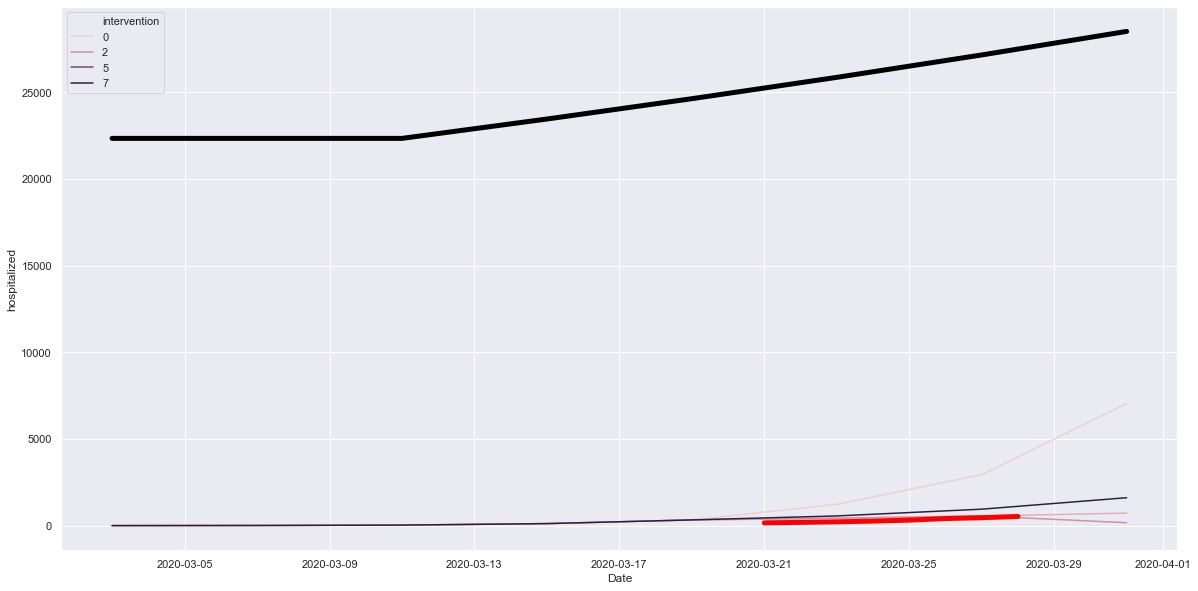

In [142]:
COUNTRY="USA"
STATE="FL"
combined_df = pd.DataFrame()
for i in (0,1,2,7):
    intervention = INTERVENTIONS[i]
    model_df = model_state(COUNTRY, STATE, intervention)
    model_df['intervention'] = i 
    combined_df = combined_df.append(model_df) 
    
#Filter the output to a closer time range for the scale
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
end_date = datetime.today() + timedelta(days=5)
mask = (combined_df['Date'] <= end_date)
combined_df = combined_df.loc[mask]

#
sb.set(rc={'figure.figsize':(20,10)})
ax = sb.lineplot(x="Date", 
                  y='Pred. Hosp.',
                  hue="intervention",
                  markers=True,
                  dashes=False,
                  data=combined_df
                 )

ax = sb.lineplot(x="Date", 
                  y='Avail. Hosp. Beds',
                  linewidth=5,
                  color="black",
                  markers=True,
                  dashes=False,
                  data=combined_df
                 )

#------------------
#--- Pull in the CoronaDataScraper for actuals
#------------------ 

df = pd.read_csv("http://covidtracking.com/api/states/daily.csv") #latest data direct from CDS

#Filter the output of CDS's timeseries to start with the projections earliest date (CDS has much more data)
df['Date'] = pd.to_datetime(df['date'], format='%Y%m%d')
start_date = combined_df.Date.min()  #grab earliest date 
#df = df.loc[(df['Date'] >= start_date)]

df = df[(df.state == STATE)]
ax = sb.lineplot(x="Date", 
                  y='hospitalized',  
                  color="red",
                  linewidth = 5,
                  markers = True, 
                  data=df
                 )

In [134]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 7
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Note                        32 non-null     object        
 1   Date                        32 non-null     datetime64[ns]
 2   Timestamp                   32 non-null     float64       
 3   R                           32 non-null     float64       
 4   Effective R.                28 non-null     float64       
 5   Beg. Susceptible            32 non-null     float64       
 6   New Inf.                    32 non-null     float64       
 7   Curr. Inf.                  32 non-null     float64       
 8   Recov. or Died              32 non-null     float64       
 9   End Susceptible             32 non-null     float64       
 10  Actual Reported             24 non-null     float64       
 11  Pred. Hosp.                 32 non-null     float64       
 1

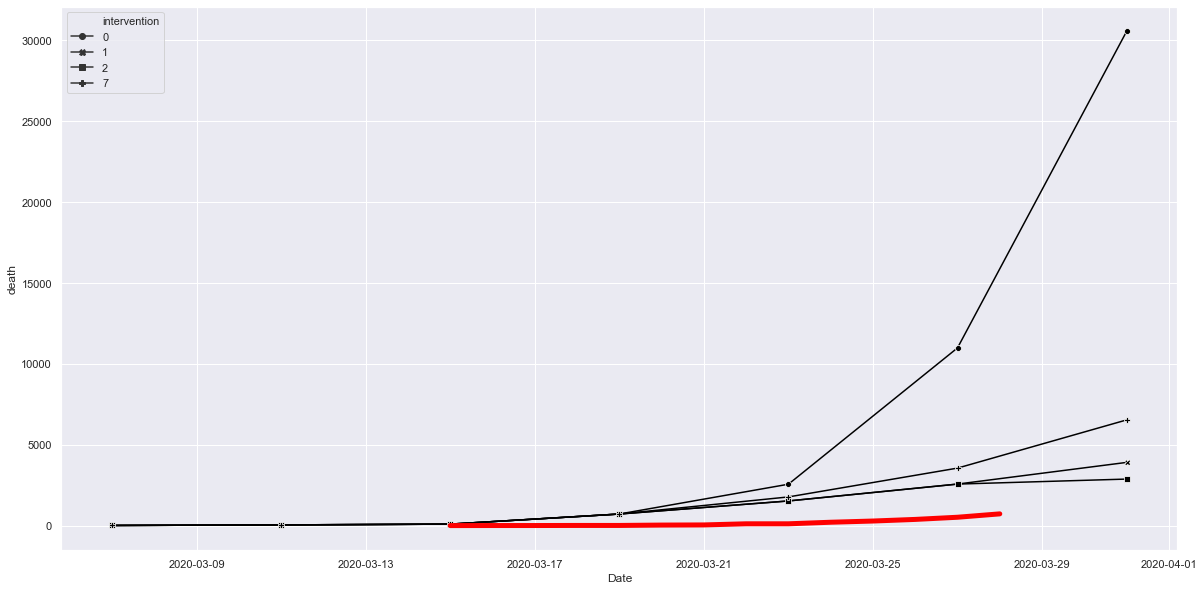

In [133]:

ax = sb.lineplot(x="Date", 
                  y='Cum. Deaths',
                  style="intervention",
                  legend="full",
                  color="black",
                  markers=True,
                  dashes=False,
                  data=combined_df
                 )

#Dataset = CDSDataset() #-- pulls from CAN github
#df = Dataset.get_timeseries_by_country_state(COUNTRY, STATE,1)
df = pd.read_csv("http://covidtracking.com/api/states/daily.csv") #latest data direct from CDS

#Filter the output of CDS's timeseries to start with the projections earliest date (CDS has much more data)
df['Date'] = pd.to_datetime(df['date'], format='%Y%m%d')
start_date = combined_df.Date.min()  #grab earliest date 
#df = df.loc[(df['Date'] >= start_date)]

df = df[(df.state == STATE)]
ax = sb.lineplot(x="Date", 
                  y='death',  
                  color="red",
                  linewidth = 5,
                  markers = True, 
                  data=df
                 )

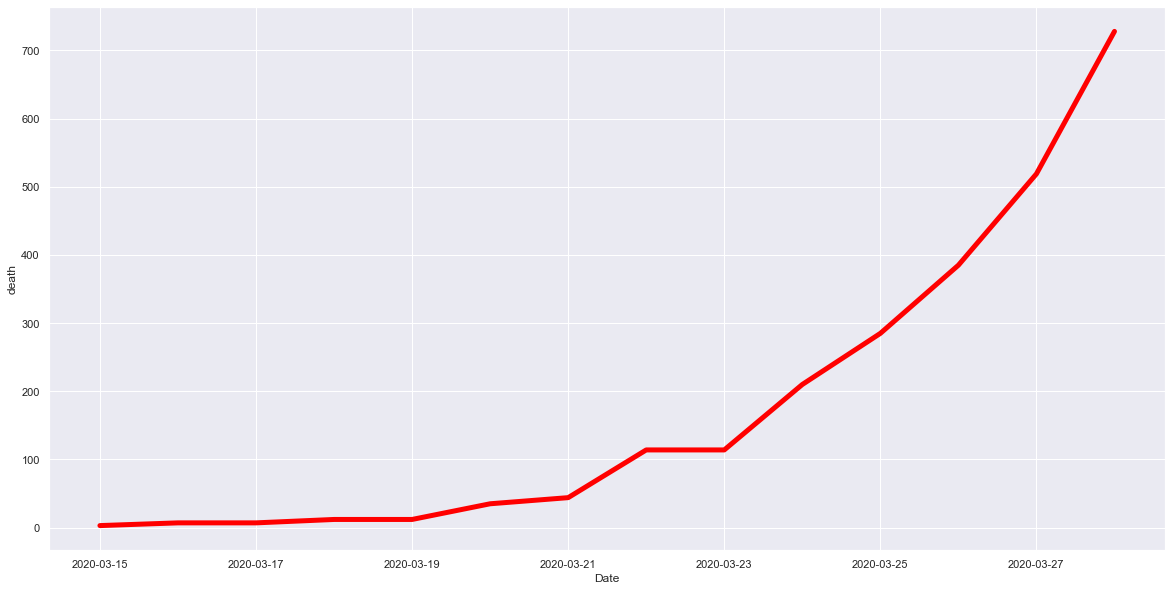

In [136]:
#Dataset = CDSDataset() #-- pulls from CAN github
#df = Dataset.get_timeseries_by_country_state(COUNTRY, STATE,1)
df = pd.read_csv("http://covidtracking.com/api/states/daily.csv") #latest data direct from CDS

#Filter the output of CDS's timeseries to start with the projections earliest date (CDS has much more data)
df['Date'] = pd.to_datetime(df['date'], format='%Y%m%d')
start_date = combined_df.Date.min()  #grab earliest date 
#df = df.loc[(df['Date'] >= start_date)]

df = df[(df.state == STATE)]
ax = sb.lineplot(x="Date", 
                  y='death',  
                  color="red",
                  linewidth = 5,
                  data=df
                 )

In [137]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 37 to 1255
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      25 non-null     int64         
 1   state                     25 non-null     object        
 2   positive                  25 non-null     float64       
 3   negative                  25 non-null     float64       
 4   pending                   4 non-null      float64       
 5   hospitalized              8 non-null      float64       
 6   death                     14 non-null     float64       
 7   total                     25 non-null     int64         
 8   hash                      25 non-null     object        
 9   dateChecked               25 non-null     object        
 10  totalTestResults          25 non-null     int64         
 11  fips                      25 non-null     int64         
 12  deathIncrease        